In [1]:
import numpy as np
import pandas as pd

from tqdm import tqdm

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances

from lightfm.data import Dataset

from math import sqrt

import scipy.sparse as sp
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
import scipy 

C:\Users\kiril\miniconda3\envs\gpu_env\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


# load long ratings matrix

In [2]:
movies_ratings = pd.read_csv('long_ratings.csv')
movies_ratings

,Wikipedia_movie_ID,userId,rating
0,975900,251,2.0
1,975900,741,2.5
2,975900,1888,3.5
3,975900,1932,1.5
4,975900,2547,2.5
...,...,...,...
7225385,34980460,143508,3.5
7225386,34980460,154703,3.0
7225387,34980460,172224,3.5
7225388,34980460,201236,3.5


# collaborative filtering

In [3]:
def rmse(prediction, ground_truth):
    prediction = np.nan_to_num(prediction)[ground_truth.nonzero()].flatten()
    ground_truth = np.nan_to_num(ground_truth)[ground_truth.nonzero()].flatten()
    mse = mean_squared_error(prediction, ground_truth)
    
    return sqrt(mse)

In [4]:
def apk(actual, predicted, k=3):
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)


def batch_mapk(actual, predicted, k=3):
    all_apk = []
    for act, pred in zip(actual, predicted):
        all_apk.append(apk(act, pred, k))
    return np.mean(all_apk)


def generate_predictions_and_actuals_mapk(predicted_scores, user_item_matrix, relevance_threshold, k, batch_size=1000):
    for i in range(0, user_item_matrix.shape[0], batch_size):
        # Порция данных
        user_batch = user_item_matrix[i:i + batch_size]

        # Пример предсказаний модели: здесь надо заменить на настоящий вызов вашей модели
        predicted = np.argsort(-predicted_scores)[:, :k]

        # Определяем релевантные товары
        actual = []
        for user_id in range(user_batch.shape[0]):
            user_row = user_batch[user_id]
            relevant_indices = user_row.indices[user_row.data >= relevance_threshold]
            actual.append(list(set(relevant_indices)))

        yield actual, predicted

In [5]:
def dcg_score(y_true, y_score, k=10, gains="exponential"):
    """Discounted cumulative gain (DCG) at rank k
    Parameters
    ----------
    y_true : array-like, shape = [n_samples]
        Ground truth (true relevance labels).
    y_score : array-like, shape = [n_samples]
        Predicted scores.
    k : int
        Rank.
    gains : str
        Whether gains should be "exponential" (default) or "linear".
    Returns
    -------df
    DCG @k : float
    """
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    if gains == "exponential":
        gains = 2 ** y_true - 1
    elif gains == "linear":
        gains = y_true
    else:
        raise ValueError("Invalid gains option.")

    # highest rank is 1 so +2 instead of +1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gains / discounts)

def ndcg_at_k(actual, predictions, k=10):
    ndcg_scores = []
    for (act_indices, act_scores), (pred_indices, pred_scores) in zip(actual, predictions):
        mapping = dict(zip(act_indices, act_scores))

        # Формируем результирующий массив (соответствие исходных оценок предсказанным)
        act_ratings = []
        for idx in pred_indices[0]:
            if idx in mapping:
                act_ratings.append(mapping[idx])
            else:
                act_ratings.append(0)


        # print(act_indices, act_scores, act_ratings)
        # print(pred_indices[0], pred_scores[0])
        dcg = dcg_score(act_ratings, pred_scores[0], k)
        idcg = dcg_score(act_ratings, act_ratings, k)
        ndcg = dcg / idcg if idcg > 0 else 0

        ndcg_scores.append(ndcg)

    return np.mean(ndcg_scores)

# Генератор, выдающий батчи актуальных рейтингов и предсказаний модели
def generate_predictions_and_actuals_ndcg(predicted_scores, user_item_matrix, batch_size, k):
    for i in range(0, user_item_matrix.shape[0], batch_size):
        user_batch = user_item_matrix[i:i + batch_size]

        # Сюда подставить предсказания модели для нашего батча юзеров (массив)
        predictions = []
        # predictions_indices = np.array([(-scores).argsort()[:k] for scores in predicted_scores])
        predictions_ratings = np.array([np.sort(scores)[-k:][::-1] for scores in predicted_scores])
        predictions_indices = np.argsort(-predicted_scores)[:, :k]
        # predictions_ratings = predicted_scores[:, predictions_indices]
        predictions.append((predictions_indices, predictions_ratings))

        # Достаем релевантные товары для батча
        actual = []
        for user_id in range(user_batch.shape[0]):
            user_row = user_batch.getrow(user_id)
            # Реальные рейтинги для индексов, где они больше нуля
            relevant_ratings = user_row.data
            relevant_indices = user_row.indices
            actual.append((relevant_indices, relevant_ratings))

        yield actual, predictions

In [6]:
dataset = Dataset()
dataset.fit(users=movies_ratings['userId'].unique(), items=movies_ratings['Wikipedia_movie_ID'].unique())

In [7]:
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    "users_mapping": lightfm_mapping[0],
    "user_features_mapping": lightfm_mapping[1],
    "items_mapping": lightfm_mapping[2],
    "item_features_mapping": lightfm_mapping[3],
}
lightfm_mapping["users_inv_mapping"] = {v: k for k, v in lightfm_mapping["users_mapping"].items()}
lightfm_mapping["items_inv_mapping"] = {v: k for k, v in lightfm_mapping["items_mapping"].items()}

In [14]:
# lightfm_mapping["users_inv_mapping"]

<Axes: >

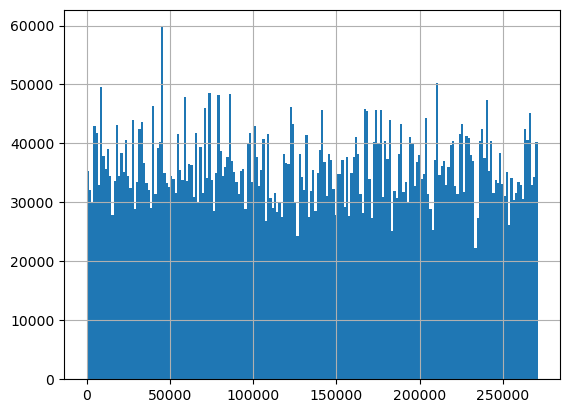

In [15]:
movies_ratings.userId.hist(bins=200)

In [16]:
movies_ratings['rating'].value_counts()

rating
4.0    1745956
3.0    1570210
3.5    1102172
2.0     621788
5.0     587083
2.5     537491
4.5     496590
1.0     263627
1.5     166579
0.5     133894
Name: count, dtype: int64

In [17]:
movies_ratings.userId

0             251
1             741
2            1888
3            1932
4            2547
            ...  
7225385    143508
7225386    154703
7225387    172224
7225388    201236
7225389    231356
Name: userId, Length: 7225390, dtype: int64

movies_ratings_cols = ['userId', 'Wikipedia_movie_ID', 'rating']
movies_ratings_train, movies_ratings_test = train_test_split(movies_ratings, 
                                                             test_size=0.2, 
                                                             random_state=42,
                                                             stratify=movies_ratings.userId)

movies_ratings_train.to_csv('train_matrix.csv', index=False)
movies_ratings_test.to_csv('test_matrix.csv', index=False)

In [48]:
import pandas as pd
movies_ratings_train = pd.read_csv('train_test/train_matrix.csv')
movies_ratings_test = pd.read_csv('train_test/test_matrix.csv')

In [4]:
movies_ratings_train.shape

(5780312, 3)

In [5]:
movies_ratings_test.shape

(1445078, 3)

In [6]:
movies_ratings_test

,Wikipedia_movie_ID,userId,rating
0,129524,118806,4.0
1,195388,2547,4.0
2,348292,99870,3.0
3,1065748,229710,3.5
4,20179720,233395,3.0
...,...,...,...
1445073,18618306,263311,4.0
1445074,14119255,118524,1.0
1445075,113651,73497,4.0
1445076,537416,110933,2.0


In [50]:
# movies_ratings_train.userId.hist()

In [51]:
# movies_ratings_test.userId.hist()

In [49]:
movies_ratings_cols = ['userId', 'Wikipedia_movie_ID', 'rating']
X_train, weights_train = (
    dataset.build_interactions([tuple(i) for i in movies_ratings_train[movies_ratings_cols].values]))
X_test, weights_test = (
    dataset.build_interactions([tuple(i) for i in movies_ratings_test[movies_ratings_cols].values]))

In [50]:
matrix_train = pd.DataFrame.sparse.from_spmatrix(weights_train)
matrix_test = pd.DataFrame.sparse.from_spmatrix(weights_test)

In [132]:
lightfm_mapping['items_mapping']

{975900: 0,
 10408933: 1,
 6631279: 2,
 171005: 3,
 77856: 4,
 21926710: 5,
 156558: 6,
 1364293: 7,
 26067101: 8,
 25960460: 9,
 261237: 10,
 12008535: 11,
 4951456: 12,
 21449578: 13,
 12053509: 14,
 1369204: 15,
 2647998: 16,
 1254263: 17,
 7028314: 18,
 5664529: 19,
 5894429: 20,
 12788657: 21,
 27556929: 22,
 4300418: 23,
 8669450: 24,
 33059372: 25,
 3740032: 26,
 164387: 27,
 7767613: 28,
 164388: 29,
 22985953: 30,
 1630107: 31,
 3550323: 32,
 1765938: 33,
 7460227: 34,
 1305819: 35,
 6752142: 36,
 27002888: 37,
 6305925: 38,
 196176: 39,
 2509881: 40,
 28742538: 41,
 26137128: 42,
 31505444: 43,
 336846: 44,
 27463222: 45,
 3249964: 46,
 21906878: 47,
 15007384: 48,
 3310726: 49,
 3033993: 50,
 1588008: 51,
 5696825: 52,
 103021: 53,
 1940449: 54,
 73842: 55,
 6703617: 56,
 21737016: 57,
 362719: 58,
 30353952: 59,
 21271533: 60,
 7696753: 61,
 17379289: 62,
 10705531: 63,
 4459059: 64,
 413207: 65,
 4069274: 66,
 3681139: 67,
 35923481: 68,
 5549065: 69,
 171058: 70,
 2608958

In [23]:
# 2 подход - через svd подставить 1 - первуб матрицу, 2 - третья матрица
user_similarity = pairwise_distances(matrix_train, metric='cosine')
item_similarity = pairwise_distances(matrix_train.T, metric='cosine')

n_users = matrix_train.shape[0]
n_movies = matrix_train.shape[1]

In [16]:
# 2 подход - через svd подставить 1 - первуб матрицу, 2 - третья матрица
user_similarity = pairwise_distances(weights_train, metric='cosine')
print('good')
item_similarity = pairwise_distances(weights_train.T, metric='cosine')

n_users = weights_train.shape[0]
n_movies = weights_train.shape[1]

good


In [24]:
n_users

9452

In [25]:
n_movies

18401

In [26]:
user_similarity.shape

(9452, 9452)

### Наивный подход

Средняя оценка топ N похожих юзеров

$$
r_{u,i} = \frac{\sum_{u' \in U} r_{u',i}}{N}
$$

In [164]:
def naive_predict(top):
    top_similar_ratings = np.zeros((n_users, top, n_movies))
    for i in tqdm(range(n_users)):
        top_sim_users = user_similarity[i].argsort()[1:top + 1]
        top_similar_ratings[i] = matrix_train.values[top_sim_users]
        
    pred = np.zeros((n_users, n_movies))
    for i in range(n_users):
        pred[i] = top_similar_ratings[i].sum(axis=0) / top
    
    return pred

def naive_predict_item(top):
    top_similar_ratings = np.zeros((n_movies, top, n_users))

    for i in tqdm(range(n_movies)):
        top_sim_movies = item_similarity[i].argsort()[1:top + 1]
        top_similar_ratings[i] = matrix_train.values.T[top_sim_movies]
        
    pred = np.zeros((n_movies, n_users))
    for i in range(n_movies):
        pred[i] = top_similar_ratings[i].sum(axis=0) / top
    
    return pred.T

In [165]:
# %%time
pred_user = naive_predict(10)
pred_item = naive_predict_item(10)

100%|██████████████████████████████████████████████████████████████████████████| 18401/18401 [1:30:29<00:00,  3.39it/s]


In [166]:
print('User-based CF RMSE: ' + str(rmse(pred_user, matrix_test.values)))
print('Item-based CF RMSE: ' + str(rmse(pred_item, matrix_test.values)))

User-based CF RMSE: 2.155137017146241
Item-based CF RMSE: 1.7518084185891054


In [167]:
all_mapk = []
for actual, predicted in generate_predictions_and_actuals_mapk(pred_user, csr_matrix(matrix_test), relevance_threshold=4, k=10, batch_size=1000):
    current_mapk = batch_mapk(actual, predicted, k=10)
    all_mapk.append(current_mapk)

print("User-based MAP@k:", np.mean(all_mapk))

all_mapk = []
for actual, predicted in generate_predictions_and_actuals_mapk(pred_item, csr_matrix(matrix_test), relevance_threshold=4, k=10, batch_size=1000):
    current_mapk = batch_mapk(actual, predicted, k=10)
    all_mapk.append(current_mapk)

print("Item-based MAP@k:", np.mean(all_mapk))

User-based MAP@k: 0.03622064450180269
Item-based MAP@k: 0.019514149631853724


In [168]:
all_ndcg_scores = []
for actual, predictions in generate_predictions_and_actuals_ndcg(pred_user, csr_matrix(matrix_test), batch_size=1000, k=10):
    ndcg_score = ndcg_at_k(actual, predictions, k=10)
    all_ndcg_scores.append(ndcg_score)
mean_ndcg = np.mean(all_ndcg_scores)
print(f"User-based Средний NDCG@{10}: {mean_ndcg}")

all_ndcg_scores = []
for actual, predictions in generate_predictions_and_actuals_ndcg(pred_item, csr_matrix(matrix_test), batch_size=1000, k=10):
    ndcg_score = ndcg_at_k(actual, predictions, k=10)
    all_ndcg_scores.append(ndcg_score)

mean_ndcg = np.mean(all_ndcg_scores)
print(f"Item-based Средний NDCG@{10}: {mean_ndcg}")

User-based Средний NDCG@10: 0.4166974746409462
Item-based Средний NDCG@10: 0.20972063765445617


### На основе средних оценок пользователей и матрицы “похожести”

$$
r_{u,i} = \bar r_u + \frac{\sum_{u' \in U} simil(u, u') \cdot (r_{u',i} - \bar r_{u'})}{\sum_{u' \in U} \left|simil(u, u')\right|}
$$

In [27]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [28]:
matrix_train = pd.DataFrame.sparse.from_spmatrix(weights_train)
matrix_test = pd.DataFrame.sparse.from_spmatrix(weights_test)

In [29]:
%%time
pred_item_mean = predict(matrix_train.values, item_similarity, type='item')
pred_user_mean = predict(matrix_train.values, user_similarity, type='user')

CPU times: total: 2min 30s
Wall time: 15.6 s


In [30]:
print('User-based CF RMSE: ' + str(rmse(pred_user_mean, matrix_test.values)))
print('Item-based CF RMSE: ' + str(rmse(pred_item_mean, matrix_test.values)))

User-based CF RMSE: 2.71505222755063
Item-based CF RMSE: 3.3548775308601524


In [31]:
all_mapk = []
for actual, predicted in generate_predictions_and_actuals_mapk(pred_user_mean, csr_matrix(matrix_test), relevance_threshold=4, k=10, batch_size=1000):
    current_mapk = batch_mapk(actual, predicted, k=10)
    all_mapk.append(current_mapk)

print("User-based MAP@k:", np.mean(all_mapk))

all_mapk = []
for actual, predicted in generate_predictions_and_actuals_mapk(pred_item_mean, csr_matrix(matrix_test), relevance_threshold=4, k=10, batch_size=1000):
    current_mapk = batch_mapk(actual, predicted, k=10)
    all_mapk.append(current_mapk)

print("Item-based MAP@k:", np.mean(all_mapk))

User-based MAP@k: 0.05298589031016373
Item-based MAP@k: 2.0000000000000003e-06


In [38]:
all_ndcg_scores = []
for actual, predictions in generate_predictions_and_actuals_ndcg(pred_user_mean, csr_matrix(matrix_test), batch_size=1000, k=10):
    ndcg_score = ndcg_at_k(actual, predictions, k=10)
    all_ndcg_scores.append(ndcg_score)
mean_ndcg = np.mean(all_ndcg_scores)
print(f"User-based Средний NDCG@{10}: {mean_ndcg}")

all_ndcg_scores = []
for actual, predictions in generate_predictions_and_actuals_ndcg(pred_item_mean, csr_matrix(matrix_test), batch_size=1000, k=10):
    ndcg_score = ndcg_at_k(actual, predictions, k=10)
    all_ndcg_scores.append(ndcg_score)

mean_ndcg = np.mean(all_ndcg_scores)
print(f"Item-based Средний NDCG@{10}: {mean_ndcg}")

User-based Средний NDCG@10: 0.3013336482441426
Item-based Средний NDCG@10: 0.0


### PCA

In [76]:
# PCA
import numpy as np
from sklearn.decomposition import PCA


pca = PCA(n_components=0.8)
pca.fit(matrix_train.values)
print(pca.explained_variance_ratio_)
#print(pca.singular_values_)

[0.05201892 0.03886896 0.02661655 ... 0.00015905 0.00015898 0.00015886]


In [83]:
pca.explained_variance_ratio_[:500].sum()

0.53333205

### Model-based Collaborative Filtering

$
X = USV_T
$

$USV_T \approx X'$ , X' - приближение матрицы X


In [84]:
%%time
u, s, vt = svds(matrix_train.values, k=500)
s_diag_matrix = np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)

CPU times: total: 4min 19s
Wall time: 1min 23s


In [85]:
print('CF MSE: ' + str(rmse(X_pred, matrix_test.values)))

CF MSE: 2.7714053163549988


In [68]:
# k=10
all_mapk = []
for actual, predicted in generate_predictions_and_actuals_mapk(X_pred, csr_matrix(matrix_test), relevance_threshold=4, k=10, batch_size=1000):
    current_mapk = batch_mapk(actual, predicted, k=10)
    all_mapk.append(current_mapk)

print("Final MAP@k:", np.mean(all_mapk))

Final MAP@k: 0.03792255653591328


In [69]:
# k=10
all_ndcg_scores = []
for actual, predictions in generate_predictions_and_actuals_ndcg(X_pred, csr_matrix(matrix_test), batch_size=1000, k=10):
    ndcg_score = ndcg_at_k(actual, predictions, k=10)
    all_ndcg_scores.append(ndcg_score)
mean_ndcg = np.mean(all_ndcg_scores)
print(f"Средний NDCG@{10}: {mean_ndcg}")

Средний NDCG@10: 0.3895810248335271


In [72]:
# k=100
all_mapk = []
for actual, predicted in generate_predictions_and_actuals_mapk(X_pred, csr_matrix(matrix_test), relevance_threshold=4, k=10, batch_size=1000):
    current_mapk = batch_mapk(actual, predicted, k=10)
    all_mapk.append(current_mapk)

print("Final MAP@k:", np.mean(all_mapk))

Final MAP@k: 0.031084254904297025


In [73]:
# k=100
all_ndcg_scores = []
for actual, predictions in generate_predictions_and_actuals_ndcg(X_pred, csr_matrix(matrix_test), batch_size=1000, k=10):
    ndcg_score = ndcg_at_k(actual, predictions, k=10)
    all_ndcg_scores.append(ndcg_score)
mean_ndcg = np.mean(all_ndcg_scores)
print(f"Средний NDCG@{10}: {mean_ndcg}")

Средний NDCG@10: 0.393674405982534


In [86]:
# k=500
all_mapk = []
for actual, predicted in generate_predictions_and_actuals_mapk(X_pred, csr_matrix(matrix_test), relevance_threshold=4, k=10, batch_size=1000):
    current_mapk = batch_mapk(actual, predicted, k=10)
    all_mapk.append(current_mapk)

print("Final MAP@k:", np.mean(all_mapk))

Final MAP@k: 0.023861425319177162


In [88]:
# k=500
all_ndcg_scores = []
for actual, predictions in generate_predictions_and_actuals_ndcg(X_pred, csr_matrix(matrix_test), batch_size=1000, k=10):
    ndcg_score = ndcg_at_k(actual, predictions, k=10)
    all_ndcg_scores.append(ndcg_score)
mean_ndcg = np.mean(all_ndcg_scores)
print(f"Средний NDCG@{10}: {mean_ndcg}")

Средний NDCG@10: 0.4142432285035184


## EASE

In [40]:
train_users = movies_ratings_train.userId.unique()
test_users = movies_ratings_test.userId.unique()

all_included = np.intersect1d(train_users, test_users)

In [41]:
train_df = movies_ratings_train.loc[movies_ratings_train.userId.isin(all_included)].copy()
test_df = movies_ratings_test.loc[movies_ratings_test.userId.isin(all_included)].copy()

In [42]:
df = pd.concat([train_df, test_df])

In [43]:
item2id = {k:v for v, k in enumerate(df.Wikipedia_movie_ID.unique())}
user2id = {k:v for v, k in enumerate(df.userId.unique())}

id2item = {k:v for v, k in item2id.items()}
id2user = {k:v for v, k in user2id.items()}

train_df['user_id'] = train_df.userId.apply(lambda x: user2id[x])
train_df['item_id'] = train_df.Wikipedia_movie_ID.apply(lambda x: item2id[x])
test_df['user_id'] = test_df.userId.apply(lambda x: user2id[x])
test_df['item_id'] = test_df.Wikipedia_movie_ID.apply(lambda x: item2id[x])

train_df.sample(5)

,Wikipedia_movie_ID,userId,rating,user_id,item_id
684839,6135549,2975,4.0,1180,7051
3712333,32112949,135747,3.0,9149,498
3593833,31701975,260551,3.5,7736,2086
354263,1034719,194455,3.5,9260,722
4553633,277158,247573,1.0,3460,3708


In [44]:
# train_grouped = movies_ratings_train.groupby('user_id').apply(
#     lambda x: [t1 for t1 in zip(x.item_id)]).reset_index()

# train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [t1 for t1 in zip(x.item_id)]).reset_index()

test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

C:\Users\kiril\AppData\Local\Temp\ipykernel_11916\1174031457.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


In [45]:
matrix = sp.coo_matrix(
    (np.ones(train_df.shape[0]), (train_df['user_id'], train_df['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<9452x18401 sparse matrix of type '<class 'numpy.float64'>'
	with 5780312 stored elements in COOrdinate format>

In [46]:
%%time

# Обучаем конечную модель
# Мы взяли реализацию из RecBole
# 
def fit_ease(X, reg_weight=100):
    
 # gram matrix
    G = X.T @ X

    # add reg to diagonal
    G += reg_weight * sp.identity(G.shape[0])

    # convert to dense because inverse will be dense
    G = G.todense()

    # invert. this takes most of the time
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    # zero out diag
    np.fill_diagonal(B, 0.)
    
    return B

w = fit_ease(matrix)

CPU times: total: 8min 43s
Wall time: 54.2 s


In [56]:
def get_preds(x, item2id, id2item):

    user_items = [t[0] for t in x]
    encoded = [item2id[t] for t in user_items if t in item2id]

    # Составляем вектор интеракций человека
    vector = np.zeros(len(item2id))
    vector[encoded] = 1

    vector = sp.csr_matrix(vector)

    preds = np.array(vector.dot(w))[0]#.toarray()
    preds[encoded==1] = -np.inf

    # ranks = np.argsort(-preds)
    # decoded = [id2item[t] for t in ranks][:10]
    
    return preds

In [57]:
test_grouped['ease_preds'] = test_grouped.test_interactions.apply(lambda x: get_preds(x, item2id, id2item))
test_grouped.head()

,user_id,test_interactions,ease_preds
0,0,"[(1173,), (2007,), (1281,), (357,), (741,), (1...","[-0.02937505657436947, 0.003478014480497466, 0..."
1,1,"[(2913,), (5485,), (136,), (1908,), (1108,), (...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,"[(6635,), (94,), (4173,), (2312,), (5825,), (5...","[-0.030211751340364804, 0.02016465126562201, 0..."
3,3,"[(85,), (1353,), (1387,), (5203,), (2711,), (8...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,"[(2757,), (2609,), (1165,), (5655,), (874,), (...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [181]:
preds_ease = test_grouped['ease_preds'].to_numpy()
shape = pred_item_mean.shape

def transform_preds(preds_ease, target_shape):
    flat_preds = []
    for array in preds_ease:
        flat_preds.extend(array)
    
    transformed = np.array(flat_preds).reshape(target_shape)
    return transformed

transformed_preds = transform_preds(preds_ease, shape)
transformed_preds.shape

(9452, 18401)

### Делаем сопоставление между индексами в matrix_test и индексами предсказанных товаров

In [184]:
indexes = np.arange(0, transformed_preds.shape[1])
pred_items_order = [lightfm_mapping['items_mapping'][id2item[t]] for t in indexes]
sorted_indices = np.argsort(pred_items_order)
transformed_preds = transformed_preds[:, sorted_indices]

In [185]:
all_mapk = []
for actual, predicted in generate_predictions_and_actuals_mapk(transformed_preds, csr_matrix(matrix_test), relevance_threshold=4, k=10, batch_size=1000):
    current_mapk = batch_mapk(actual, predicted, k=10)
    all_mapk.append(current_mapk)

print("EASE MAP@k:", np.mean(all_mapk))

all_ndcg_scores = []
for actual, predictions in generate_predictions_and_actuals_ndcg(transformed_preds, csr_matrix(matrix_test), batch_size=1000, k=10):
    ndcg_score = ndcg_at_k(actual, predictions, k=10)
    all_ndcg_scores.append(ndcg_score)

mean_ndcg = np.mean(all_ndcg_scores)
print(f"EASE Средний NDCG@{10}: {mean_ndcg}")

EASE MAP@k: 0.0035895901109706417
EASE Средний NDCG@10: 0.18631967549391754
